# Example of usage Spark OCR for Handwritting Detection & Recognition

## Install spark-ocr python packge
Need to specify:
- secret
- license
- aws credentials

In [6]:
secret = ""
license = ""
AWS_ACCESS_KEY_ID = ""
AWS_SECRET_ACCESS_KEY = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../target/scala-2.11"

In [ ]:
%%bash
if python -c 'import google.colab' &> /dev/null; then
    echo "Run on Google Colab!"
    echo "Install Open JDK"
    apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
    java -version
fi

In [7]:
import os
import sys

if AWS_ACCESS_KEY_ID != "":
    os.environ["AWS_ACCESS_KEY_ID"] = AWS_ACCESS_KEY_ID
    os.environ["AWS_SECRET_ACCESS_KEY"] = AWS_SECRET_ACCESS_KEY
    
if license:
    os.environ['JSL_OCR_LICENSE'] = license
    
if 'google.colab' in sys.modules:
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
  os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
#%pip install ../../python/dist/spark-ocr-3.7.0+spark30.tar.gz

In [ ]:
# install from PYPI using secret
#%pip install spark-ocr==$version\.spark30 --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade

## Initialization of spark session
Need specify path to `spark-ocr-assembly.jar` or `secret`

In [4]:
from pyspark import SparkConf
from sparkocr import start

spark = start(secret=secret, jar_path = spark_ocr_jar_path, nlp_version="3.1.3")

spark

Spark version: 3.0.2
Spark OCR version: 3.7.0



## Read images and display it

In [5]:
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images


    Image #0:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/LCT04596-SLA-3-2.jpg
    Resolution: 0 dpi
    Width: 1224 px
    Height: 1584 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


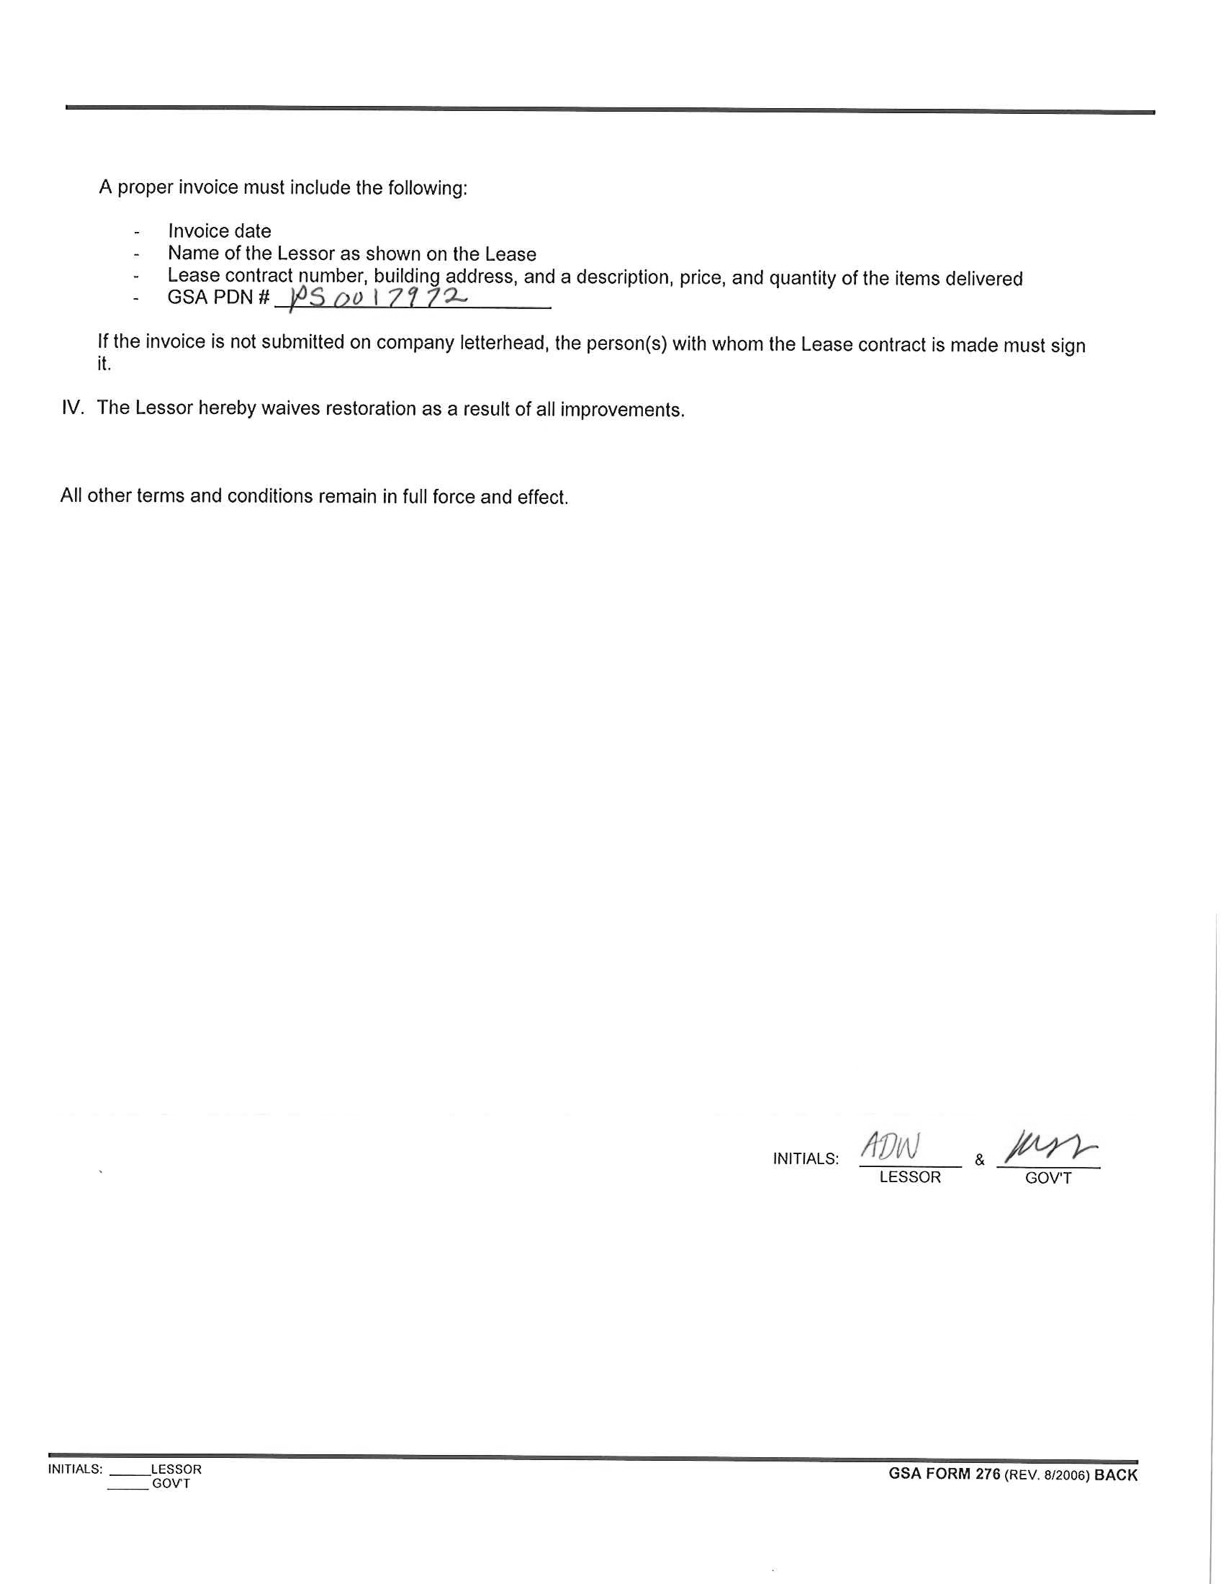

In [25]:
imagePath = "/Users/chico/Downloads/jsl-work/HTR/LCT04596-SLA-3-2.jpg"
image_df = spark.read.format("binaryFile").load(imagePath)
display_images(BinaryToImage().transform(image_df), "image")

## Define OCR Pipeline

In [26]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")
handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("handwritten_regions") \
    .setScoreThreshold(0.4)

draw_regions = ImageDrawRegions() \
   .setInputCol("image") \
   .setInputRegionsCol("handwritten_regions") \
   .setOutputCol("image_with_regions") \
   .setFontSize(16) \
   .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    draw_regions
])

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB


## Run pipeline and show results


    Image #0:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/LCT04596-SLA-3-2.jpg
    Resolution: 0 dpi
    Width: 1224 px
    Height: 1584 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


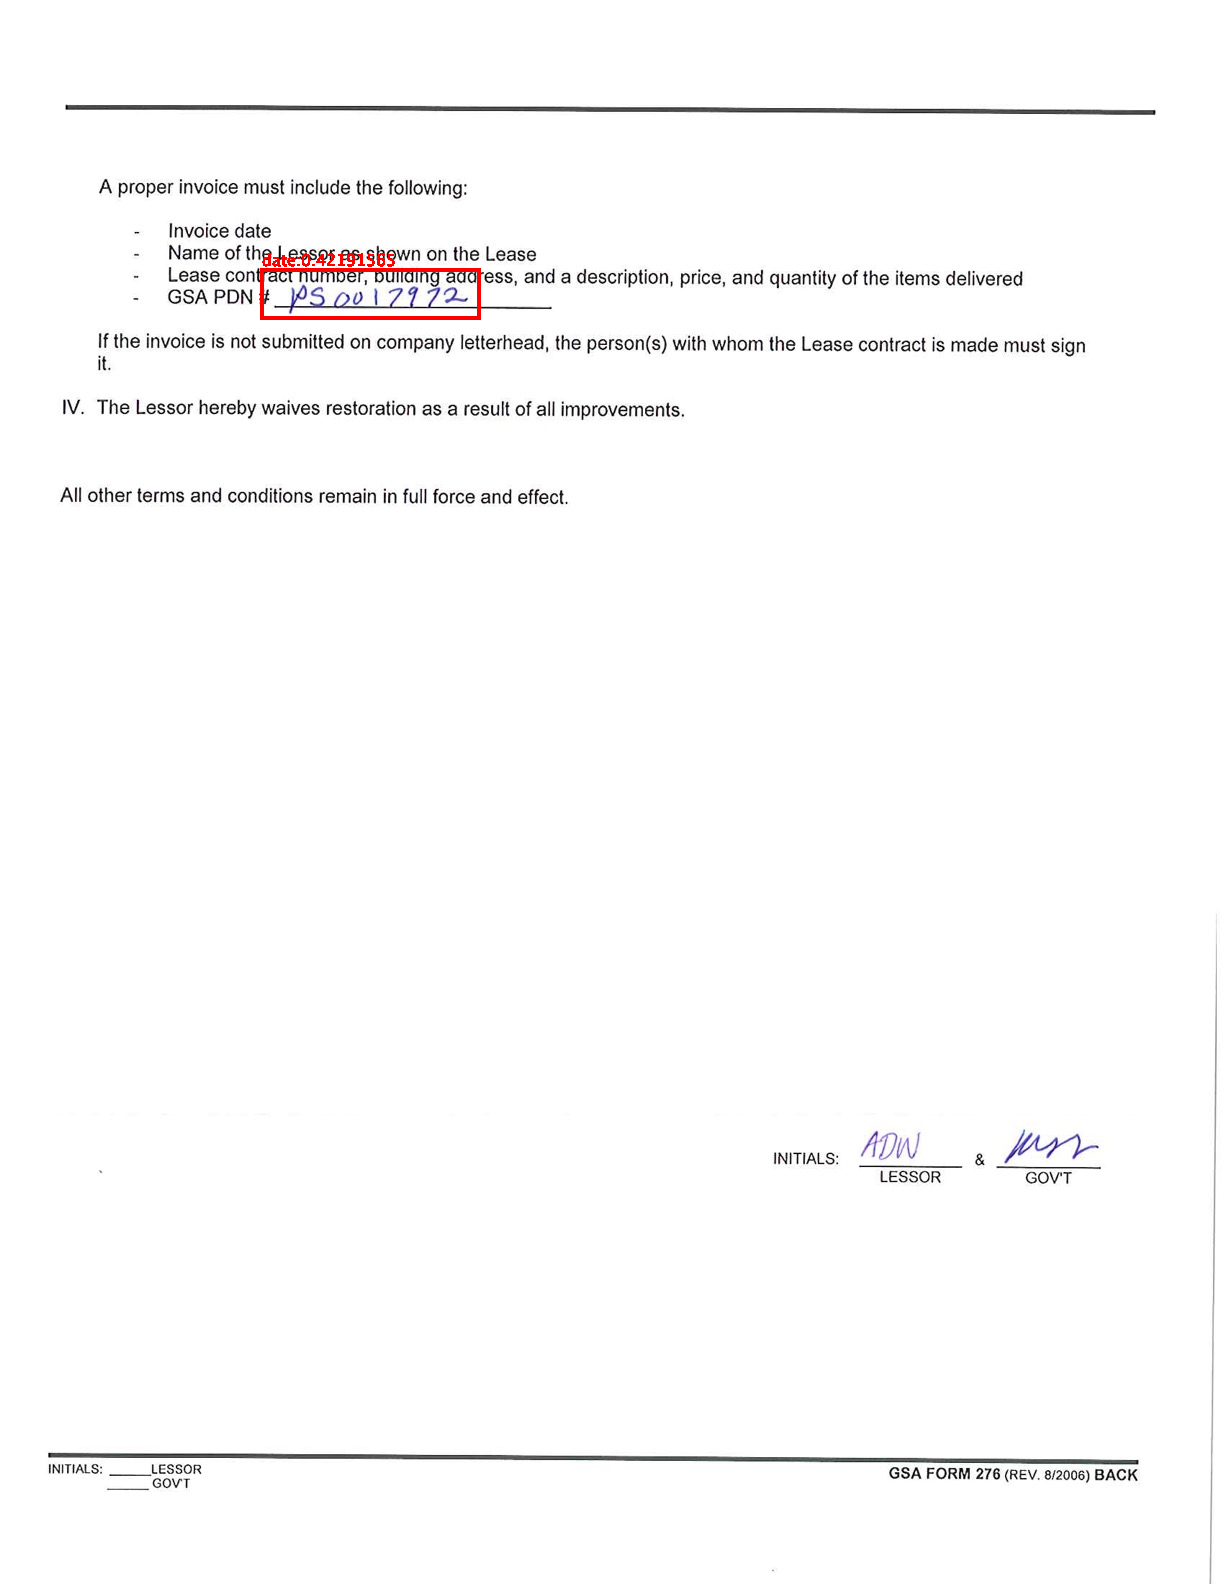

In [27]:
result =  pipeline.transform(image_df)
display_images(result, "image_with_regions")

### Output format for regions

In [28]:
result.select("handwritten_regions").printSchema()

root
 |-- handwritten_regions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = false)
 |    |    |-- label: string (nullable = false)



### Display coordinates and scores of regions

In [29]:
path_array = f.split(result['path'], '/')

result.withColumn("coordinate", f.explode_outer(f.col("handwritten_regions"))) \
    .withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn('handwritten', f.size(f.col("handwritten_regions")) > 0) \
    .select("filename", "handwritten", "coordinate") \
    .show(truncate=False)

+--------------------+-----------+---------------------------------------------------+
|filename            |handwritten|coordinate                                         |
+--------------------+-----------+---------------------------------------------------+
|LCT04596-SLA-3-2.jpg|true       |[2, 0, 262.0, 270.0, 217.0, 48.0, 0.42191565, date]|
+--------------------+-----------+---------------------------------------------------+



In [16]:
result1 = result.withColumn("coordinate", f.explode_outer(f.col("handwritten_regions"))) \
    .withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
    .withColumn('handwritten', f.size(f.col("handwritten_regions")) > 0) 

result1.printSchema()

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- handwritten_regions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- index: integer (nullable = false)
 |    |    |-- page: integer (nullable = false)
 |    |    |-- x: float (nullable = false)
 |    |    |-- y: float (nullable = false)
 |    |    |-- width: float (nullable = false)
 |    |    |-- height: float (nullable = false)
 |    |    |-- score: float (nullable = false)
 |    |    |-- label: string (nullable = false)
 |-- image_

In [ ]:
result2 = result1.withColumn("region1", transform(col("region"), (col: Column) => ))

In [30]:

binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)


pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")

handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("region") \
    .setScoreThreshold(0.4) \
    .setOutputLabels(['date', 'name', 'title', 'address', 'others'])

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("handwritten")


pipeline = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    splitter
])

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB


In [32]:
result = pipeline.transform(image_df)
result.printSchema()

root
 |-- handwritten: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- region: struct (nullable = true)
 |    |-- index: integer (nullable = false)
 |    |-- page: integer (nullable = false)
 |    |-- x: float (nullable = false)
 |    |-- y: float (nullable = false)
 |    |-- width: float (nullable = false)
 |    |-- height: float (nullable = false)
 |    |-- score: float (nullable = false)
 |    |-- label: string (nullable = false)
 |-- path: string (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- length: long (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (n

In [33]:
handwriting = result.select("region", "image")

In [34]:
handwriting.select("region").show(truncate=False)

+---------------------------------------------------+
|region                                             |
+---------------------------------------------------+
|[2, 0, 262.0, 270.0, 217.0, 48.0, 0.42191565, date]|
+---------------------------------------------------+




    Image #0:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/LCT04596-SLA-3-2.jpg
    Resolution: 0 dpi
    Width: 217 px
    Height: 48 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


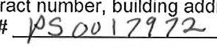

In [36]:
display_images(result, "handwritten")

In [37]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(10)

pretrained_model = ("image_handwritten_text_recognition_span0819", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("handwritten") \
    .setOutputCol("handwritten_text")

pipeline2 = PipelineModel(stages=[
    recoginzer
])

result2 = pipeline2.transform(result)

image_handwritten_text_recognition_span0819 download started this may take some time.
Approximate size to download 64.3 MB


In [38]:
result2.select("handwritten_text").show(truncate=False)

+----------------+
|handwritten_text|
+----------------+
|rGumter ainge d |
+----------------+



In [39]:
result2.printSchema()

root
 |-- handwritten: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- region: struct (nullable = true)
 |    |-- index: integer (nullable = false)
 |    |-- page: integer (nullable = false)
 |    |-- x: float (nullable = false)
 |    |-- y: float (nullable = false)
 |    |-- width: float (nullable = false)
 |    |-- height: float (nullable = false)
 |    |-- score: float (nullable = false)
 |    |-- label: string (nullable = false)
 |-- path: string (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- length: long (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer

## one more test

In [40]:
imagePath = '/Users/chico/Downloads/jsl-work/HTR/LCT04746-SLA-1-_Z.jpg'

In [41]:
image_df = spark.read.format("binaryFile").load(imagePath)

In [42]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")
handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("region") \
    .setScoreThreshold(0.4)

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("handwritten")

pipeline1 = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    splitter
])

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB


In [43]:
result = pipeline1.transform(image_df)


    Image #0:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/LCT04746-SLA-1-_Z.jpg
    Resolution: 0 dpi
    Width: 123 px
    Height: 62 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


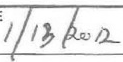

In [44]:
display_images(result, "handwritten")

In [45]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(10)

pretrained_model = ("image_handwritten_text_recognition_span0819", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("handwritten") \
    .setOutputCol("handwritten_text")

pipeline2 = PipelineModel(stages=[
    recoginzer
])

result2 = pipeline2.transform(result)

image_handwritten_text_recognition_span0819 download started this may take some time.
Approximate size to download 64.3 MB


In [46]:
result2.select("handwritten_text").show(truncate=False)

+----------------+
|handwritten_text|
+----------------+
|fisher.         |
+----------------+



## TODO need to find out a clean background example

In [47]:
imagePath = '/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png'
#LAL61969-Lease_Z.png'
#LAL61023-SLA-2-_Z.png'

image_df = spark.read.format("binaryFile").load(imagePath)

In [48]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")

handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("handwritten_regions") \
    .setScoreThreshold(0.4)

draw_regions = ImageDrawRegions() \
   .setInputCol("image") \
   .setInputRegionsCol("handwritten_regions") \
   .setOutputCol("image_with_regions") \
   .setFontSize(16) \
   .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    draw_regions
])

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB



    Image #0:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png
    Resolution: 0 dpi
    Width: 1224 px
    Height: 1584 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


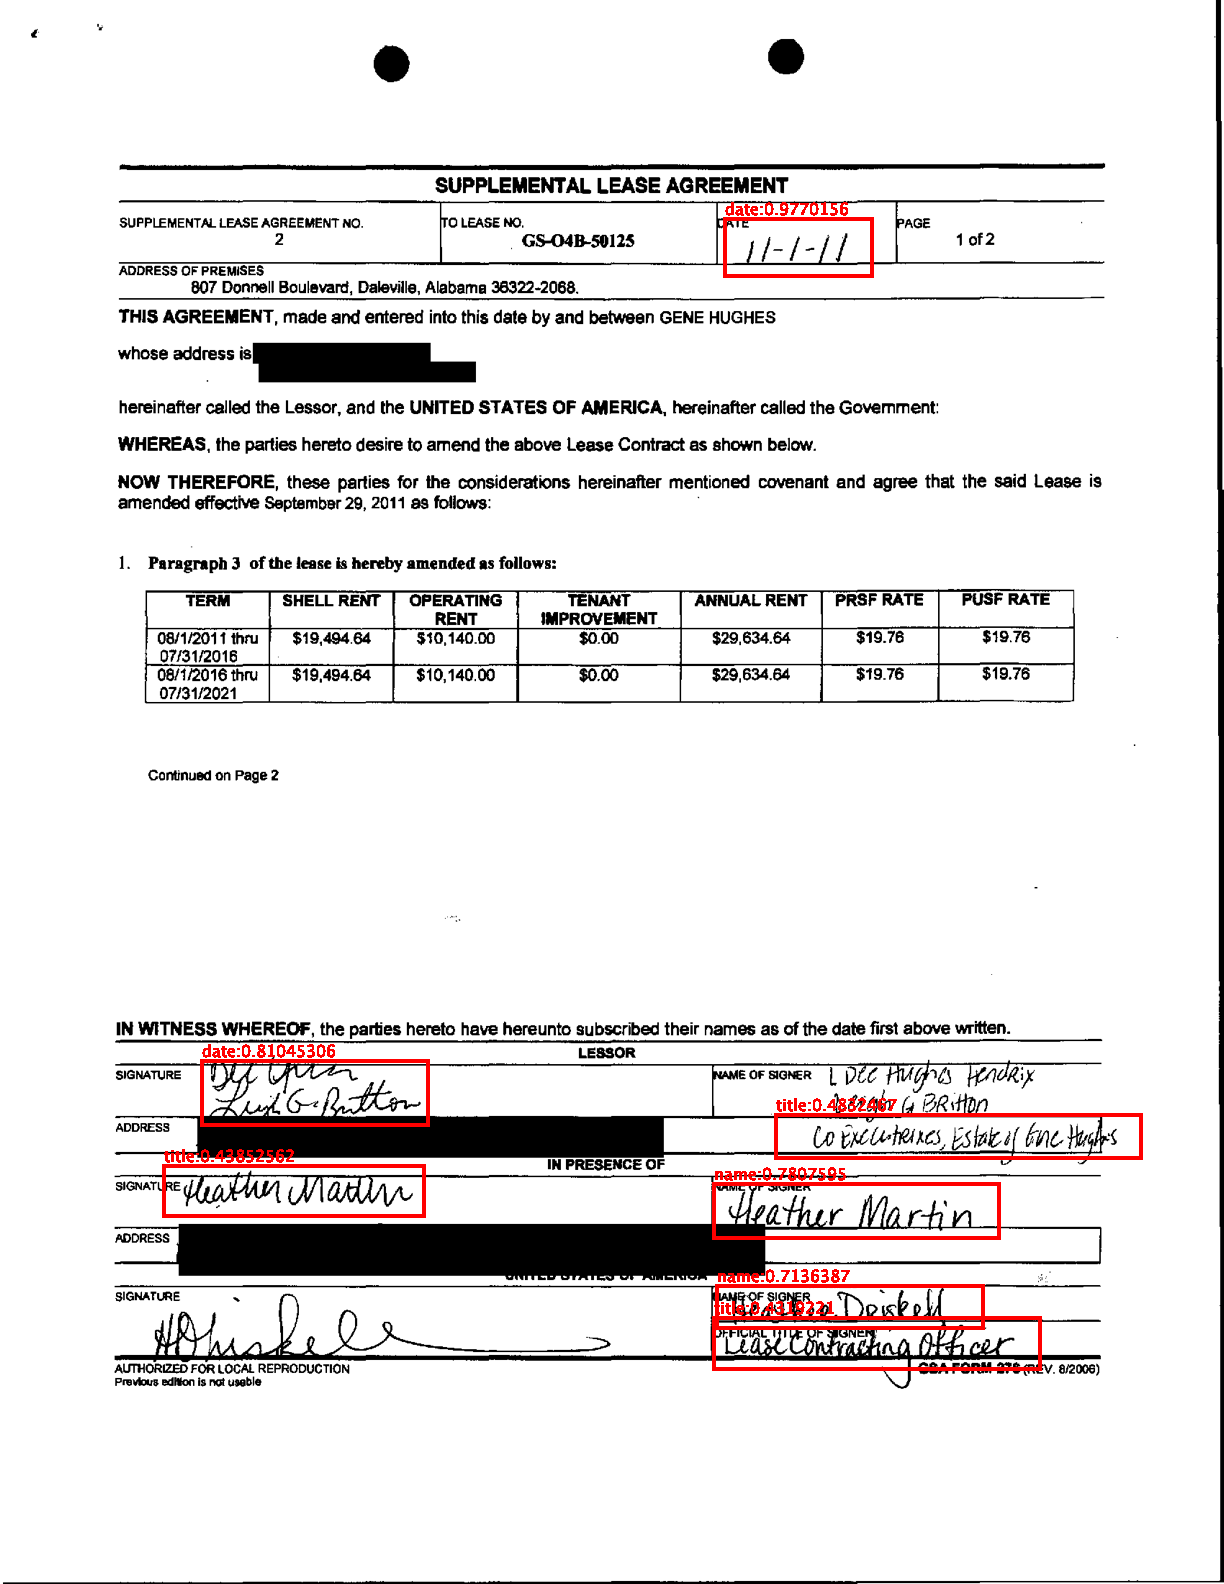

In [49]:
result =  pipeline.transform(image_df)
display_images(result, "image_with_regions")

In [50]:

binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)


pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")
handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("region") \
    .setScoreThreshold(0.4) \
    .setOutputLabels(['date', 'name', 'title', 'address', 'others'])


splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("handwritten")


pipeline1 = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    splitter
])

result = pipeline1.transform(image_df)

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB


In [51]:
result.printSchema()

root
 |-- handwritten: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- exception: string (nullable = true)
 |-- region: struct (nullable = true)
 |    |-- index: integer (nullable = false)
 |    |-- page: integer (nullable = false)
 |    |-- x: float (nullable = false)
 |    |-- y: float (nullable = false)
 |    |-- width: float (nullable = false)
 |    |-- height: float (nullable = false)
 |    |-- score: float (nullable = false)
 |    |-- label: string (nullable = false)
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- 

In [52]:
result.select("region").show(truncate=False)

+-----------------------------------------------------+
|region                                               |
+-----------------------------------------------------+
|[0, 0, 725.0, 219.0, 147.0, 57.0, 0.9770156, date]   |
|[2, 0, 202.0, 1061.0, 226.0, 64.0, 0.81045306, date] |
|[3, 0, 714.0, 1184.0, 285.0, 54.0, 0.7807595, name]  |
|[4, 0, 717.0, 1286.0, 266.0, 42.0, 0.7136387, name]  |
|[5, 0, 776.0, 1115.0, 365.0, 43.0, 0.4832467, title] |
|[6, 0, 164.0, 1166.0, 260.0, 50.0, 0.43852562, title]|
|[7, 0, 714.0, 1318.0, 326.0, 51.0, 0.4319221, title] |
+-----------------------------------------------------+




    Image #0:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png
    Resolution: 0 dpi
    Width: 147 px
    Height: 57 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


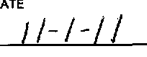


    Image #1:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png
    Resolution: 0 dpi
    Width: 226 px
    Height: 64 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


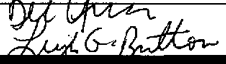


    Image #2:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png
    Resolution: 0 dpi
    Width: 285 px
    Height: 54 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


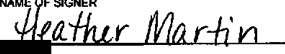


    Image #3:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png
    Resolution: 0 dpi
    Width: 266 px
    Height: 42 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


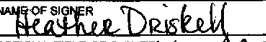


    Image #4:
    Origin: file:/Users/chico/Downloads/jsl-work/HTR/span/LAL50125-SLA-2-_Z.png
    Resolution: 0 dpi
    Width: 365 px
    Height: 43 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


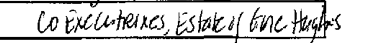

image_handwritten_text_recognition_span0819 download started this may take some time.
Approximate size to download 64.3 MB
+--------------------------+
|handwritten_text          |
+--------------------------+
|renal.                    |
|STulGRGtt en-             |
|"feather Martin           |
|myearns Derkell           |
|Coxtutencs staky tou tests|
|feather Masmn             |
|speasetentn off or.       |
+--------------------------+



In [53]:
display_images(result, "handwritten")

binary_to_image = BinaryToImage()
binary_to_image.setImageType(10)

pretrained_model = ("image_handwritten_text_recognition_span0819", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("handwritten") \
    .setOutputCol("handwritten_text")

pipeline2 = PipelineModel(stages=[
    recoginzer
])

result2 = pipeline2.transform(result)

result2.select("handwritten_text").show(truncate=False)

## the image SparkOcrImageHandwrittenDetection.ipynb used

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB

    Image #0:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 381 px
    Height: 88 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


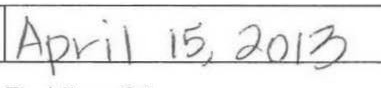


    Image #1:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 232 px
    Height: 101 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


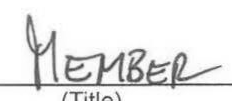


    Image #2:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 862 px
    Height: 69 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


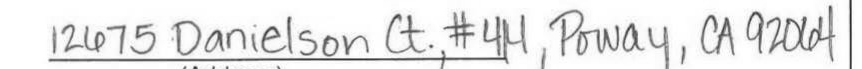


    Image #3:
    Origin: file:/Users/chico/IdeaProjects/spark-ocr/workshop/jupyter/data/handwritten/page1.jpeg
    Resolution: 0 dpi
    Width: 849 px
    Height: 71 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


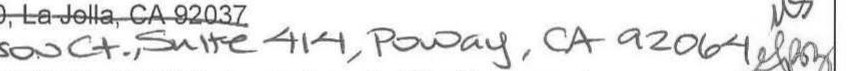

image_handwritten_text_recognition_span0819 download started this may take some time.
Approximate size to download 64.3 MB
+---------------------------------------------+
|handwritten_text                             |
+---------------------------------------------+
|(April is 2ory?                              |
|'"'"'"'&'!'#'&!&!&!&! !&!                    |
|2LET5 Danielson (t. # UM, Poway, AK 92Nd !   |
|totatet#fer-GsEARE t/2, poway, (A azowi los) |
+---------------------------------------------+



In [83]:



imagePath = "./data/handwritten/page1.jpeg"

image_df = spark.read.format("binaryFile").load(imagePath)


binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")
handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("region") \
    .setScoreThreshold(0.4)

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("handwritten")

pipeline1 = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    splitter
])

result = pipeline1.transform(image_df)

display_images(result, "handwritten")

binary_to_image = BinaryToImage()
binary_to_image.setImageType(10)

pretrained_model = ("image_handwritten_text_recognition_span0819", "en", "public/ocr/models")
recoginzer = ImageHandwrittenTextRecognizer() \
    .pretrained(*pretrained_model) \
    .setInputCol("handwritten") \
    .setOutputCol("handwritten_text")

pipeline2 = PipelineModel(stages=[
    recoginzer
])

result2 = pipeline2.transform(result)

result2.select("handwritten_text").show(truncate=False)